# Hyperparameter Tuning Methods Comparision: Example

Cross validation approach based on the following [repo](https://github.com/roamanalytics/roamresearch/tree/master/BlogPosts/Hyperparameter_tuning_comparison)


In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%aimport hpt_cmp

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import dataset_loader as ds
import model_loader as mdl
import seaborn as sns

from hpt_cmp import *

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score ,make_scorer, log_loss, recall_score
from tqdm import tqdm_notebook, tnrange
from skopt.space import Real, Integer, Categorical

In [294]:
# basic sklearn classification DS
dsBunch = ds.load('digits')
#dsBunch = ds.load('census_csv')
data = (dsBunch.data, dsBunch.target)
n_features = dsBunch.data.shape[1]
n_features

64

# MLPClassifier

Parameters we tune for the MLPClassifier ([full documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)):
> `hidden_layer_sizes`: tuple <br>
> `activation`: {'identity', 'logistic', 'tanh', *'relu'*} <br>
> `solver`: {‘lbfgs’, ‘sgd’, *‘adam’*} <br>
> `alpha`: float, *0.0001* --- regularization term <br>
> `learning_rate`: {*‘constant’*, ‘invscaling’, ‘adaptive’} <br>
> `learning_rate_init`: double, *0.001* <br>
> `random_state` <br>
> `momentum`: float, *0.9* <br>
> `nesterovs_momentum`: bool, *True* <br>
> `early_stopping`: bool, *False* <br>

In [295]:
d_features = n_features*2
hls = [(d_features,)*5, (n_features,)*5, (d_features,)*2, (n_features,)*2, (d_features,), (n_features)]
alpha = [0.0001, 0.001, 0.01]
lr = ['adaptive'] #'constant','invscaling',
lr_init = [0.00001, 0.0001, 0.001, 0.01, 0.1]
rs = [0]

# sklean paramgrid
pg = {
    'hidden_layer_sizes': hls,
    'alpha': alpha,
    'learning_rate': lr,
    'learning_rate_init': lr_init,
    'random_state': rs
}

# hyperopt paramgird
hg={
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes',hls),
    'alpha': hp.loguniform('alpha', np.log(alpha[0]), np.log(alpha[-1])),
    'learning_rate': hp.choice('learning_rate',lr),
    'learning_rate_init': hp.loguniform('learning_rate_init', np.log(lr_init[0]),np.log(lr_init[-1])),
    'random_state': hp.choice('random_state', rs)
}

# skopt paramgrid 
bg = {
    'hidden_layer_sizes': Categorical(hls),
    'alpha': Real(np.log(alpha[0]), np.log(alpha[-1]), 'loguniform'),
    'learning_rate': Categorical(lr),
    'learning_rate_init': Real(np.log(lr_init[0]),np.log(lr_init[-1]), 'logunifrom'),
    'random_state': rs
}

# base model parameters
base = {
    'hidden_layer_sizes':(n_features,), 
    'alpha':0.001,
    'learning_rate': lr[0],
    'learning_rate_init': 0.001,
    'random_state':0}

In [296]:
# define MLPClassifier
hpt_objs = [
        HPT_OBJ('Tree of Parzen Est.', hg, tpe_search, {}),
        #HPT_OBJ('Bayes Search', bg, baysian_search, {'n_iter':MAX_ITER}),
        HPT_OBJ('Baseline', base, run_baseline, {}),
        #HPT_OBJ('Grid Search', pg, grid_search, {'refit': 'acc'}),
        HPT_OBJ('Random Search', pg, random_search, {'refit':'acc','n_iter': MAX_ITER}),
]

loss = {
    'acc': make_scorer(accuracy_score),
    #'loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True, labels=dsBunch.target),
    #make_scorer(log_loss(lables=dsBunch.target_names)),
    #'recall': make_scorer(recall_score)
}

mlpc ={
    'model': neural_network.MLPClassifier,
    'hpt_objs': hpt_objs,
    'loss': make_scorer(accuracy_score),
    'metric': accuracy_score,
}

In [297]:
# run tuning with all the specified algorithms
res = cmp_hpt_methods(data, **mlpc)

5 3


In [298]:
sum_res = []
for r in res:
    t = np.array(r[INNER_RES]['mean_fit_time']).mean()
    #if r[HPT_METHOD] == 'Bayes Search':
    sum_res.append((r[HPT_METHOD], r[CV_TIME],len(r[INNER_RES]['params']), r[TEST_ACC], r[BEST_PARAMS], np.array(r[INNER_RES]['mean_test_score']).mean() ))
    #else:
     #   sum_res.append((r[HPT_METHOD], t, len(r[INNER_RES]['params']), r[TEST_ACC], r[BEST_PARAMS], np.array(r[INNER_RES]['mean_test_acc']).mean() ))
                   
df = pd.DataFrame(sum_res, columns=[HPT_METHOD, 'TIME', PARAMS_SAMPLED, TEST_ACC, BEST_PARAMS, 'SCORE'])

In [299]:
df

,HPT method,TIME,Parameters sampled,Test accuracy,Best Parameters,SCORE
0,Tree of Parzen Est.,9.095831,5,0.977778,"{'alpha': 0.0013471327274982546, 'hidden_layer...",0.969267
1,Baseline,2.784230,1,0.964815,"{'hidden_layer_sizes': (64,), 'alpha': 0.001, ...",0.964210
2,Random Search,153.129147,30,0.972222,"{'random_state': 0, 'learning_rate_init': 0.00...",0.736622


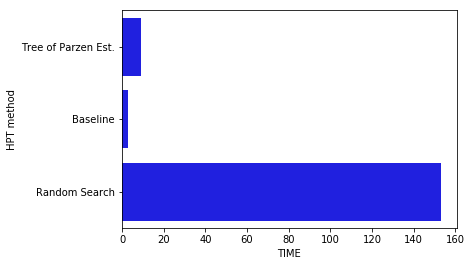

<Figure size 432x288 with 0 Axes>

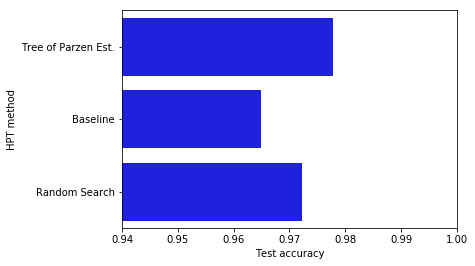

In [302]:
# plot comparison
plt.figure()
sns.barplot(x='TIME', y=HPT_METHOD,data =df, color='b')
plt.figure()
# plot accuracy comparison
fig, ax =plt.subplots()
ax.set(xlim=(0.94, 1.0))
sns.barplot(x=TEST_ACC, y=HPT_METHOD, ax = ax,data =df, color='b')

In [293]:
pd.DataFrame(df[BEST_PARAMS].tolist())

,alpha,hidden_layer_sizes,learning_rate,learning_rate_init,random_state
0,0.000117,8,adaptive,0.001086,0
1,0.001000,"(8,)",adaptive,0.001000,0
2,0.000100,8,adaptive,0.010000,0


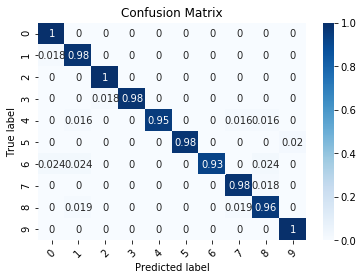

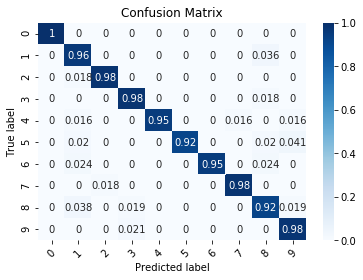

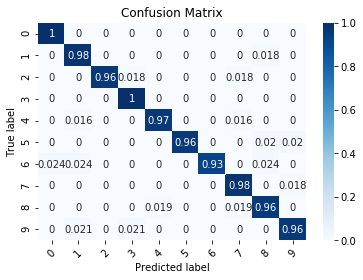

In [316]:
for r in res:
    plot_confusion_matrix(r[CONF_MATRIX], dsBunch.target_names)

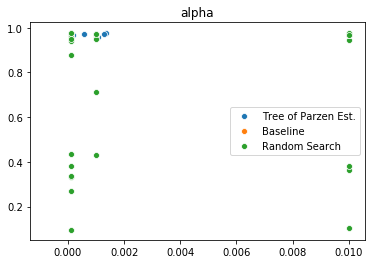

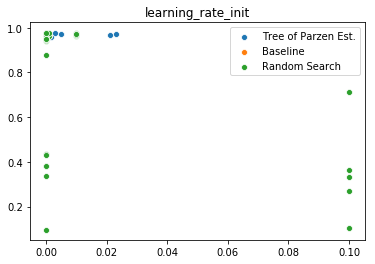

In [321]:
for param in ['alpha', 'learning_rate_init']:
    plt.figure()
    for r in res:
        ax = sns.scatterplot(x='param_'+param, y=scoring, data=r[INNER_RES], label=r[HPT_METHOD])
        ax.set_title(param)